In [ ]:
# Remove this
#! pip install torch==2.3 torchvision torchaudio --index-url https://download.pytorch.org/whl/cu118
! pip install --upgrade torch torchvision==0.15.0+cu118 --index-url https://download.pytorch.org/whl/cu118

#! pip install stacchip
#! pip install geopandas

! pip install contextily

SyntaxError: invalid syntax (4269583495.py, line 2)

In [ ]:

import warnings

import geoarrow.pyarrow as ga
import numpy as np
import pyarrow as pa
import pyarrow.parquet as pq
import pystac_client
import requests
import torch
import yaml
from box import Box

import stacchip.indexer
from stacchip.chipper import Chipper
from stacchip.indexer import Sentinel2Indexer
from torchvision.transforms import v2

import geopandas as gpd
import pandas as pd

from shapely.geometry import Polygon
import matplotlib.pyplot as plt

import math
import os
import random

import timm
import torch
import torch.nn.functional as F
from einops import rearrange, reduce, repeat
from torch import nn
from torchvision.transforms import v2

from src.backbone import Transformer
from src.factory import DynamicEmbedding
from src.utils import posemb_sincos_2d_with_gsd

torch.set_float32_matmul_precision("medium")
os.environ["TORCH_CUDNN_V8_API_DISABLED"] = "1"

#from src.model import ClayMAEModule

import contextily as cx
import rasterio
from rasterio.plot import show

from shapely.geometry import box

import sklearn
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE


warnings.filterwarnings("ignore")

#### Load mining data and visualize

In [109]:
# Load mine data
mine_data = gpd.read_file('data/pitlakes').to_crs(epsg=4326)

# Print info about dataset
print(mine_data['Material'].value_counts())
print(len(mine_data))

Material
coal         27
Al           24
Au           22
limestone    18
diamond      13
Fe           13
U             6
sand          4
phosphate     1
Cu            1
Name: count, dtype: int64
1004


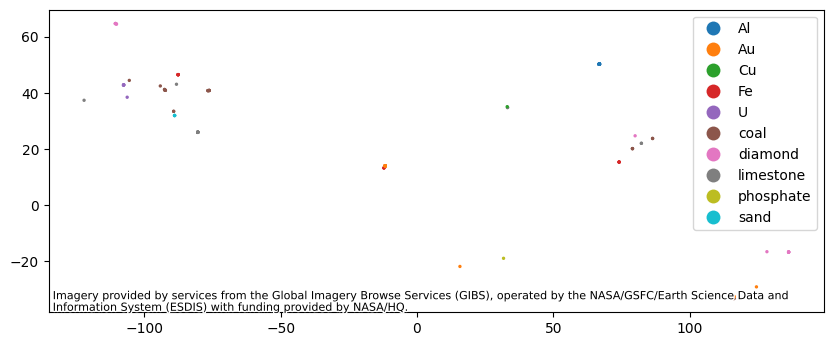

In [110]:
# Visualize with satellite basemap
providers = cx.providers.flatten()

ax = mine_data.plot(column = 'Material', markersize = 2, legend = True, legend_kwds={'bbox_to_anchor': (1, 1)},figsize = (10,10))
cx.add_basemap(ax, crs=mine_data.crs, source=providers['NASAGIBS.BlueMarble'])

In [140]:
# Get mines in Minnesota

states = gpd.read_file('data/state_boundaries')
mn = states[states['STUSPS']=='MN']
mn = mn.to_crs(epsg = 4326).geometry.unary_union # MN was multipolygon

mn_mines = mine_data[mine_data.geometry.within(mn_union)]

#### Visualize Minnesota mines

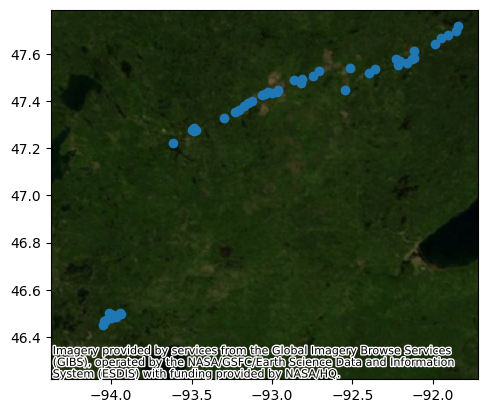

In [141]:
ax = mn_mines.plot()
cx.add_basemap(ax, crs=mine_data.crs, source=providers['NASAGIBS.BlueMarble'])

#### Grab embeddings for mines and random embeddings

In [157]:
type(gpd.read_parquet('data/60cm/rgbir_cog/43091/m_4309101_ne_15_060_20210815.parquet', columns=["geometry"]))


geopandas.geodataframe.GeoDataFrame

In [ ]:
mine_embeddings = []
folders = []

# Go through all embedding folders
folder_list = os.listdir('data/60cm/rgbir_cog/')

for folder in folder_list: # Get list of folders to search through
    folders.append(f"data/60cm/rgbir_cog/{folder}")

for folder in folders: # In each folder, go through parquet files and add file to list if it contains mines
    folder_path = folder
    parquet_files = [os.path.join(folder_path, f) for f in os.listdir(folder_path) if f.endswith(".parquet")]

    for file in parquet_files:
        pqs = gpd.read_parquet(file, columns=["geometry"])
        if not gpd.sjoin(pqs, mn_mines, how="inner", predicate="contains").empty:
            mine_embeddings.append(file)
    
len(mine_embeddings)

33

#### Label embeddings with mine/no mine

In [204]:
# Add buffer to make mine polygon

buffered_mines = gpd.GeoDataFrame(geometry = mn_mines.buffer(0.02), crs=4326)

#ax = buffered_mines.head().plot()
#cx.add_basemap(ax, crs=buffered_mines.crs, source=providers['NASAGIBS.BlueMarble'])

# Mark True if mine present in chip embedding, False if not
data = gpd.GeoDataFrame()

for emb in mine_embeddings:
    chip_embeddings = gpd.read_parquet(emb)
    chip_embeddings['mine'] = chip_embeddings.intersects(buffered_mines)
    data = pd.concat([data, chip_embeddings], ignore_index=True)

data['mine'].sum()

17

Relative variance in principal components: [0.19617602 0.09956957 0.06526317]


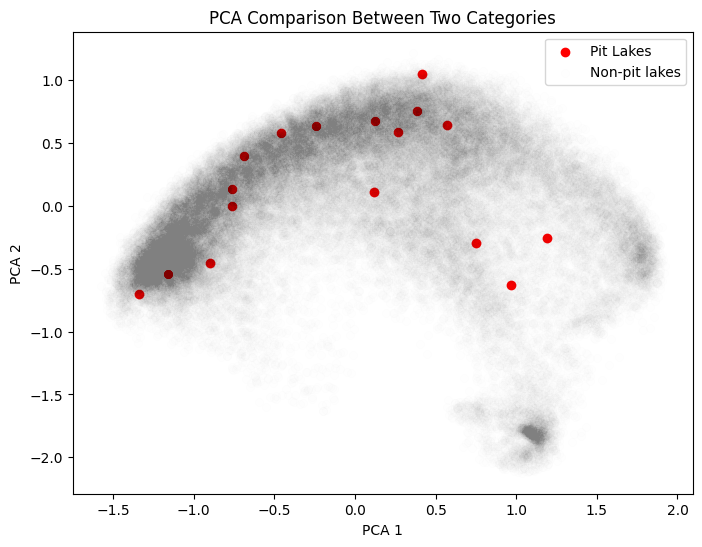

In [ ]:
# Get principle components and plot for each embedding

# Convert embeddings to array and do PCA
X =  np.vstack(data['embeddings'].values)
pca = PCA(n_components=3)
pca.fit(X)

# Check on variance explained by given # of dimensions of PCA
print("Relative variance in principal components:", pca.explained_variance_ratio_)

# Apply PCA to get first two dimensions
data['pca1'] = pca.transform(X)[:, 0]
data['pca2'] = pca.transform(X)[:, 1]

# Visualize the first two principal components with category color-coding
plt.figure(figsize=(8, 6))

# Plot for category 1
plt.scatter(data[data['mine'] == True]['pca1'], 
            data[data['mine'] == True]['pca2'], 
            color='red', label='Pit Lakes')

# Plot for category 2
plt.scatter(data[data['mine'] == False]['pca1'], 
            data[data['mine'] == False]['pca2'], 
            color='grey', label='Non-pit lakes', alpha=0.005)

plt.xlabel('PCA 1')
plt.ylabel('PCA 2')
plt.legend()
plt.title('PCA Comparison Between Two Categories')
plt.show()

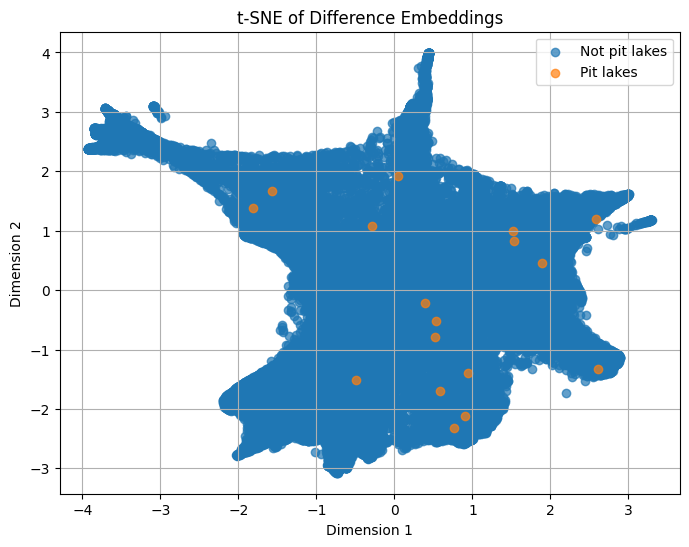

In [218]:
labels = data['mine'].values

tsne_data = np.vstack(data['embeddings'].values)

# Set up t-SNE
tsne = TSNE(n_components=2, perplexity=25, n_iter=250)
reduced_embeddings = tsne.fit_transform(tsne_data)

# Visualize the results
plt.figure(figsize=(8, 6))

custom_labels = {0: "Not pit lakes", 1: "Pit lakes"}

for label in np.unique(labels):
    mask = labels == label
    plt.scatter(reduced_embeddings[mask, 1],
                reduced_embeddings[mask, 0],
                label=custom_labels.get(label, f"Label {label}"),
                alpha=0.7)

plt.title("t-SNE of Difference Embeddings")
plt.xlabel("Dimension 1")
plt.ylabel("Dimension 2")
plt.grid(True)
plt.legend()
plt.show()

#### Visualize a few mines

In [ ]:
# Point over Indiana

lat, lon = 39.685325944000056, -87.09601677899997

# AOI around pt in Indiana
""" aoi_as_list = [[-87.09601677899997,39.685325944000056],
      [-87.19601677899997,39.75325944000056],
      [-87.09601677899997,39.685325944000056],
      [-87.09601677899997,39.75325944000056],
      [-87.09601677899997,39.685325944000056]] """

""" aoi_as_dict = {
    "type": "Polygon",
    "coordinates": [aoi_as_list],
} """

# Date range
start = "2016-01-01"
end = "2016-12-31"

POINT (-87.09601677899997 39.685325944000056)


In [87]:
# Optimize GDAL settings for cloud optimized reading
os.environ["GDAL_DISABLE_READDIR_ON_OPEN"] = "EMPTY_DIR"
os.environ["AWS_REQUEST_PAYER"] = "requester"

STAC_API = "https://earth-search.aws.element84.com/v1"
COLLECTION = "sentinel-2-l2a"

# Search the catalogue
catalog = pystac_client.Client.open(STAC_API)
search = catalog.search(
    collections=[COLLECTION],
    datetime=f"{start}/{end}",
    bbox=(lon - 1e-3, lat - 1e-3, lon + 1e-3, lat + 1e-3),
    max_items=4,
    query={"eo:cloud_cover": {"lt": 10}},
)

all_items = search.get_all_items()

# Reduce to one per date (there might be some duplicates
# based on the location)
items = []
dates = []
for item in all_items:
    if item.datetime.date() not in dates:
        items.append(item)
        dates.append(item.datetime.date())

print(f"Found {len(items)} items")

Found 2 items


In [ ]:
# Retrieve the items
assets = []
assets_urls = []
item_latlons = []
item_bboxs = []

# Show 'visual' asset for true-color composite and create list of images
for item in items:
    asset = item.assets["visual"]
    assets.append(asset)
    assets_urls.append(asset.href)
    # Get centroids of images and create buffer polygons
    image_geom = Polygon(item.geometry['coordinates'][0])
    item_latlons.append(gpd.GeoDataFrame(geometry = [image_geom]).centroid)

for item in item_latlons:
    item_bboxs.append(item.buffer(0.2))
    print(item_bboxs)


0    POINT (-87.53002 40.15442)
dtype: geometry
0    POINT (-87.37462 39.22901)
dtype: geometry
[0    POLYGON ((-87.33002 40.15442, -87.33098 40.134...
dtype: geometry]
[0    POLYGON ((-87.33002 40.15442, -87.33098 40.134...
dtype: geometry, 0    POLYGON ((-87.17462 39.22901, -87.17558 39.209...
dtype: geometry]


In [ ]:
item_bboxs

None


In [88]:
# Crop images
from rasterio.mask import mask

with rasterio.open(assets_urls[0]) as src:
    cropped_image, cropped_transform = mask(src, item_bboxs[0].geometry, crop=True)

cropped_image_data = cropped_image 
cropped_image_transform = cropped_transform 



ValueError: Input shapes do not overlap raster.

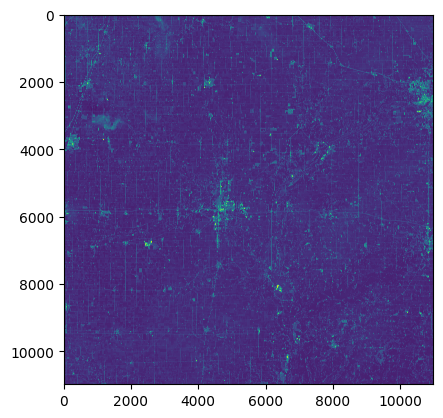

In [ ]:
with rasterio.open("tests/data/RGB.byte.tif") as src:
    out_image, out_transform = rasterio.mask.mask(src, shapes, crop=True)
    out_meta = src.meta

# Load and visualize the asset with rasterio

fig, (ax1, ax2) = plt.subplots(2)

# Create image plotting function

###

src1 = rasterio.open(assets_urls[0])
src2 = rasterio.open(assets_urls[1])
    
ax1.plt.imshow(src1.read(1))
ax2.plt.imshow(src2.read(1))
plt.show()


### Find data for AOI
The first step is to find STAC items of imagery that we want to use to create embeddings. In this example we are going to use Earth Genome's composite dataset which comes with a great STAC catalog.

We are also going to create embeddings along time so that we have multiple embeddings for the same location at different moments in time.

In [ ]:
# Point over Nevada
# lat, lon = 39.145068721560506, -119.67465363188465

# AOI around Nevada
aoi_as_list = [[-119.1256714,39.6620962],
      [-119.1302491,39.5669496],
      [-118.959961,39.5500181],
      [-118.9544679,39.638862],
      [-119.1247559,39.6578851],
      [-119.1256714,39.6620962]]

aoi_as_dict = {
    "type": "Polygon",
    "coordinates": [aoi_as_list],
}

# Date range
start = "2018-07-01"
end = "2018-09-01"

In [32]:
# Optimize GDAL settings for cloud optimized reading
os.environ["GDAL_DISABLE_READDIR_ON_OPEN"] = "EMPTY_DIR"
os.environ["AWS_REQUEST_PAYER"] = "requester"

STAC_API = "https://earth-search.aws.element84.com/v1"
COLLECTION = "sentinel-2-l2a"

# Search the catalogue
catalog = pystac_client.Client.open(STAC_API)
search = catalog.search(
    collections=[COLLECTION],
    datetime=f"{start}/{end}",
    intersects=aoi_as_dict, # CHANGED TO GET ONLY IMAGES INTERSECTING WITH AOI
    max_items=2,
    query={"eo:cloud_cover": {"lt": 10}},
)

all_items = search.get_all_items()

# Reduce to one per date (there might be some duplicates
# based on the location)
items = []
dates = []
for item in all_items:
    if item.datetime.date() not in dates:
        items.append(item)
        dates.append(item.datetime.date())

print(f"Found {len(items)} items")

Found 1 items


To speed up processing in this example, we limit the number of chips to 3 per Sentinel-2 scene. Remove this limit in a real use case.

In [ ]:
chips = []
datetimes = []
bboxs = []
chip_ids = []
item_ids = []

# Adjust desired chip dimension (pixels) 
# chip_dimension = int(224)
# stacchip.indexer.ChipIndexer.chip_size = chip_dimension # Edit default class chip size attribute
# Sentinel2Indexer.chip_size = chip_dimension

for item in items:
    print(f"Working on {item}")

    # Index the chips in the item
    indexer = Sentinel2Indexer(item)

    # Instanciate the chipper
    chipper = Chipper(indexer, assets=["red", "green", "blue", "nir", "scl"])

    # Get first chip for the "image" asset key
    for idx, (x, y, chip) in enumerate(chipper):
        #if idx > 3: # Remove this for full inference
        #    break
        del chip["scl"]
        chips.append(chip)
        datetimes.append(item.datetime)
        bboxs.append(indexer.get_chip_bbox(x, y))
        chip_ids.append((x, y))
        item_ids.append(item.id)

Working on <Item id=S2B_11SLD_20180825_1_L2A>


RasterioIOError: Read or write failed. /vsicurl/https://sentinel-cogs.s3.us-west-2.amazonaws.com/sentinel-s2-l2a-cogs/11/S/LD/2018/8/S2B_11SLD_20180825_1_L2A/B04.tif, band 1: IReadBlock failed at X offset 2, Y offset 1: TIFFReadEncodedTile() failed.

In [149]:
# Drop chips that don't intersect and corresponding chips, datetimes, chip IDs, and item IDs

bboxs_gdf = gpd.GeoDataFrame(geometry=bboxs)
aoi = Polygon(aoi_as_list)

mask = bboxs_gdf.intersects(aoi) # Create mask of bboxs of chips that intersect the AOI

chips = pd.Series(chips)[mask].tolist()
datetimes = pd.Series(datetimes)[mask].tolist()
bboxs = pd.Series(bboxs)[mask].tolist()
chip_ids = pd.Series(chip_ids)[mask].tolist()
item_ids = pd.Series(item_ids)[mask].tolist()

print("Number of chips that intersect with AOI: ")
print(len(chips))

Number of chips that intersect with AOI: 
4


In [150]:
pixels = np.array([np.array(list(chip.values())).squeeze() for chip in chips])
pixels.shape

(4, 4, 256, 256)

In [1]:
#Visualize chips

gpd.GeoDataFrame(geometry = bboxs).plot()

NameError: name 'gpd' is not defined

Prepare band metadata for passing it to the model

In [ ]:
# Extract mean, std, and wavelengths from metadata
platform = "sentinel-2-l2a"
# Retrieve the file content from the URL

url = (
    "https://raw.githubusercontent.com/Clay-foundation/model/main/configs/metadata.yaml"
)
response = requests.get(url, allow_redirects=True)

# Convert bytes to string
content = response.content.decode("utf-8")

# Load the yaml
content = yaml.safe_load(content)

metadata = Box(content)
mean = []
std = []
waves = []
# Use the band names to get the correct values in the correct order.
for band in chips[0].keys():
    mean.append(metadata[platform].bands.mean[band])
    std.append(metadata[platform].bands.std[band])
    waves.append(metadata[platform].bands.wavelength[band])

# Prepare the normalization transform function using the mean and std values.
transform = v2.Compose(
    [
        v2.Normalize(mean=mean, std=std),
    ]
)

Convert the band pixel data into the format for the model

In [ ]:
def normalize_timestamp(date):
    week = date.isocalendar().week * 2 * np.pi / 52
    hour = date.hour * 2 * np.pi / 24

    return (math.sin(week), math.cos(week)), (math.sin(hour), math.cos(hour))


times = [normalize_timestamp(dat) for dat in datetimes]
week_norm = [dat[0] for dat in times]
hour_norm = [dat[1] for dat in times]


# Prep lat/lon embedding by normalizing centroids of chip bboxs
def normalize_latlon(lat, lon):
    lat = lat * np.pi / 180
    lon = lon * np.pi / 180

    return (math.sin(lat), math.cos(lat)), (math.sin(lon), math.cos(lon))

latlons = []

for bbox in bboxs:
    centroid = bbox.centroid
    lat, lon = centroid.y, centroid.x  # Extract lat, lon from centroid
    latlons.append(normalize_latlon(lat, lon))

#latlons = [normalize_latlon(lat, lon)] * len(times) # WHY DO WE WANT THE SAME THING REPEATED?
lat_norm = [dat[0] for dat in latlons]
lon_norm = [dat[1] for dat in latlons]

# Prep gsd
gsd = [10]

# Normalize pixels
pixels = transform(pixels)
pixels = pixels.astype(np.float32) # ADDED THIS BACK IN


In [ ]:
datacube = {
    "pixels": torch.tensor(pixels, dtype=torch.float32),
    "time": torch.tensor(np.hstack((week_norm, hour_norm)), dtype=torch.float32),
    "latlon": torch.tensor(np.hstack((lat_norm, lon_norm)), dtype=torch.float32),
    "waves": torch.tensor(waves, dtype=torch.float32),
    "gsd": torch.tensor(gsd, dtype=torch.float32),
}

In [ ]:
for k, v in datacube.items():
    print(k, v.shape)

pixels torch.Size([2, 4, 256, 256])
time torch.Size([2, 4])
latlon torch.Size([2, 4])
waves torch.Size([4])
gsd torch.Size([1])


### Clay Embedder

#### Load the embedder that is stored in ExportedProgram format using **cpu**.

#### Load and run the checkpoint of the model

In [36]:
import pytorch_lightning as pl
# Add LightningModule class inheritance to access load_from_checkpoint method
#class ClayMAE(pl.LightningModule): 
#    pass

device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
ckpt = "https://huggingface.co/made-with-clay/Clay/resolve/main/clay_v1.5.ckpt"
torch.set_default_device(device)

model = ClayMAEModule.load_from_checkpoint(
    ckpt, metadata_path="configs/metadata.yaml", shuffle=False, mask_ratio=0
)
model.eval()

model = model.to(device)

RuntimeError: Unknown model (vit_large_patch14_reg4_dinov2)

In [ ]:
with torch.no_grad():
    unmsk_patch, unmsk_idx, msk_idx, msk_matrix = model.model.encoder(datacube)

# The first embedding is the class token, which is the
# overall single embedding. We extract that for PCA below.
embeddings = unmsk_patch[:, 0, :].cpu().numpy()

In [139]:
# Run the clay encoder
with torch.no_grad():
    unmsk_patch, unmsk_idx, msk_idx, msk_matrix = clay_encoder(*datacube)
# Get class embeddings
cls_embedding = unmsk_patch[:, 0, :]
# Print shape of class embeddings
cls_embedding.shape

NameError: name 'clay_encoder' is not defined

#### Load and run the exported cpu model

In [ ]:
# Get file from local exportedprogram format

! wget -q https://huggingface.co/made-with-clay/Clay/blob/main/v1.5/compiled/clay-v1.5-encoder-cpu.pt2

'wget' is not recognized as an internal or external command,
operable program or batch file.


In [ ]:
ep_embedder_cpu = torch.export.load("data/clay-v1.5-encoder-cpu.pt2").module()

Run the model with EP

In [ ]:
%%time
with torch.no_grad():
    embeddings = ep_embedder_cpu(datacube)
datacube["pixels"].shape, embeddings.shape

CPU times: total: 11.8 s
Wall time: 9.1 s


(torch.Size([2, 4, 256, 256]), torch.Size([2, 768]))

For each chip, we have an embedding of size `768`

#### Load the embedder that is stored in ExportedProgram format using **gpu**.

In [ ]:
!wget -q https://huggingface.co/made-with-clay/Clay/resolve/main/compiled/v1.0/clay-v1-encoder.pt2

In [ ]:
datacube = {k: v.to("cuda") for k, v in datacube.items()}
ep_embedder = torch.export.load("clay-v1-encoder.pt2").module()

In [ ]:
%%time
with torch.no_grad():
    embeddings = ep_embedder(datacube)
datacube["pixels"].shape, embeddings.shape

For each chip, we have an embedding of size `768`

#### Load the embedder that is stored in ONNX format using **cpu**.

In [ ]:
import onnxruntime as ort

In [ ]:
!wget -q https://huggingface.co/made-with-clay/Clay/resolve/main/compiled/v1.0/clay-v1-encoder-cpu.onnx

In [ ]:
datacube = {k: v.to("cpu") for k, v in datacube.items()}
onnx_embedder = ort.InferenceSession(
    "clay-v1-encoder-cpu.onnx", providers=["CPUExecutionProvider"]
)

In [ ]:
%%time
embeddings = onnx_embedder.run(
    [],
    {
        "cube": datacube["pixels"].numpy(),
        "time": datacube["time"].numpy(),
        "latlon": datacube["latlon"].numpy(),
        "waves": datacube["waves"].numpy(),
        "gsd": datacube["gsd"].numpy(),
    },
)[0]
embeddings.shape

For each chip, we have an embedding of size `768`

### Store the results

We create a table containing the embeddings, bounding box, the STAC item ID, the datetime of the image capture, and the chip x and y ids. Then we save that data to disk.

In [ ]:
# Write data to pyarrow table
index = {
    "datetimes": datetimes,
    "chip_ids": chip_ids,
    "item_ids": item_ids,
    "embeddings": [np.ascontiguousarray(dat) for dat in embeddings],
    "geometry": ga.as_geoarrow([dat.wkt for dat in bboxs]),
}
table = pa.table(index)
table

pyarrow.Table
datetimes: timestamp[us, tz=UTC]
chip_ids: list<item: int64>
  child 0, item: int64
item_ids: string
embeddings: list<item: float>
  child 0, item: float
geometry: extension<geoarrow.polygon<PolygonType>>
----
datetimes: [[2018-08-25 18:53:24.597000Z,2018-08-25 18:53:24.597000Z]]
chip_ids: [[[1,0],[2,0]]]
item_ids: [["S2B_11SLD_20180825_1_L2A","S2B_11SLD_20180825_1_L2A"]]
embeddings: [[[-0.12739897,0.06501336,-0.0043061064,0.093552634,0.15224756,...,0.048478447,-0.17023225,0.04420602,-0.18251786,-0.04366695],[-0.09462359,0.08339551,-0.030247303,0.114174575,0.17728658,...,0.044083178,-0.14688866,0.057765294,-0.17931639,-0.0330391]]]
geometry: [[[      -- is_valid: all not null
      -- child 0 type: double
[-118.9754053793589,-118.97146936387814,-119.15024167776343,-119.15453396559633,-118.9754053793589]
      -- child 1 type: double
[39.73345718524536,39.59514085820176,39.59196881845574,39.730269624751166,39.73345718524536]],[      -- is_valid: all not null
      -- child

In [ ]:
pq.write_table(table, "embeddings.parquet")

                         datetimes chip_ids                  item_ids  \
0 2018-08-25 18:53:24.597000+00:00   (1, 0)  S2B_11SLD_20180825_1_L2A   
1 2018-08-25 18:53:24.597000+00:00   (2, 0)  S2B_11SLD_20180825_1_L2A   

                                          embeddings  \
0  [-0.12739897, 0.06501336, -0.0043061064, 0.093...   
1  [-0.09462359, 0.08339551, -0.030247303, 0.1141...   

                                            geometry  
0  POLYGON ((-118.97541 39.73346, -118.97147 39.5...  
1  POLYGON ((-118.79625 39.73637, -118.79267 39.5...  


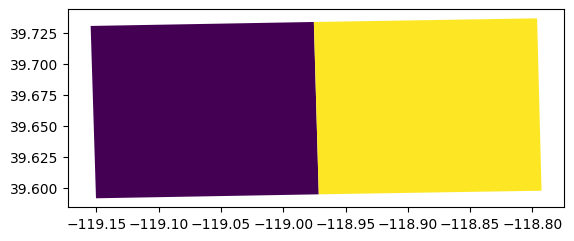

In [ ]:
# Convert into GeoDataFrame and visualize embeddings
index_gdf = gpd.GeoDataFrame(index, geometry = bboxs)
print(index_gdf.head())

# Visualize first dimension of embedding
index_gdf_first = gpd.GeoDataFrame(geometry = index_gdf['geometry'])
index_gdf_first['emb'] = index_gdf['embeddings'].apply(lambda x: x[0]) # Change 0 to visualize other dimensions

# Plot first embedding dimension
index_gdf_first.plot(column = 'emb')
plt.show()

In [ ]:
def plot_rgb(stack):
    """
    Plot the RGB bands of the given stack.

    Parameters:
    stack (xarray.DataArray): The input data array containing band information.
    """
    stack.sel(band=[1, 2, 3]).plot.imshow(rgb="band", vmin=0, vmax=2000, col_wrap=6)
    plt.show()